Выберите ряд из первого задания. Постройте его модель GARCH.

In [ ]:
!pip3 install arch

In [192]:
from arch import arch_model
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose  
from statsmodels.graphics.tsaplots import plot_predict, plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [206]:
temps = pd.read_csv("mean-monthly-air-temperature-deg.csv", index_col = 'Month', parse_dates = True, dayfirst=True).dropna()
temps.head(3)

,Deg
Month,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4


Text(0.5, 1.0, 'Mean monthly air temperature')

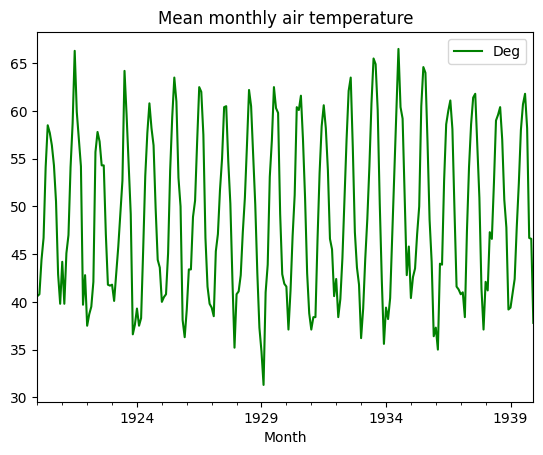

In [207]:
temps.plot(color='green')
plt.title('Mean monthly air temperature')

Text(0.5, 0.98, 'Multiplicative Decompose')

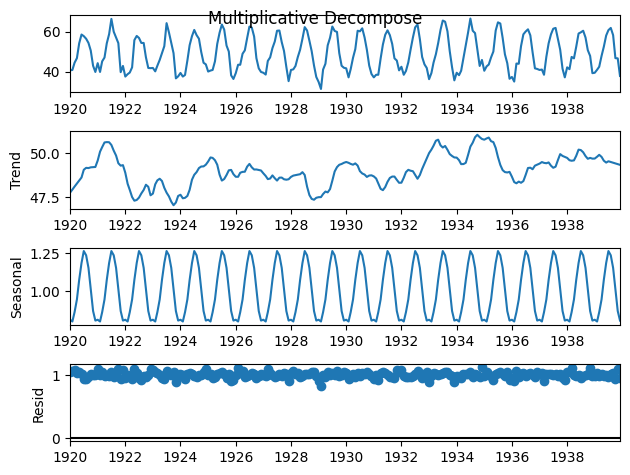

In [61]:
decompose = seasonal_decompose(temps, model='multiplicative', extrapolate_trend='freq')
decompose.plot().suptitle('Multiplicative Decompose')

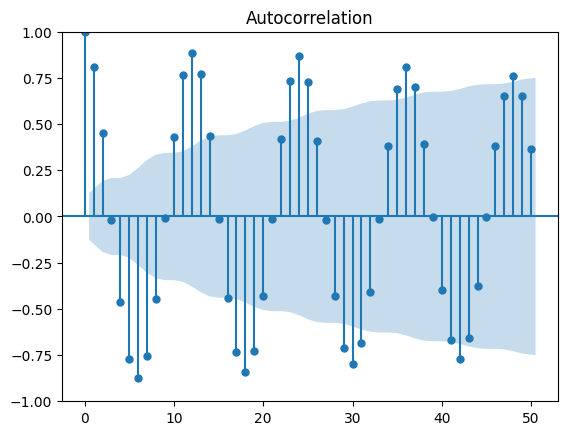

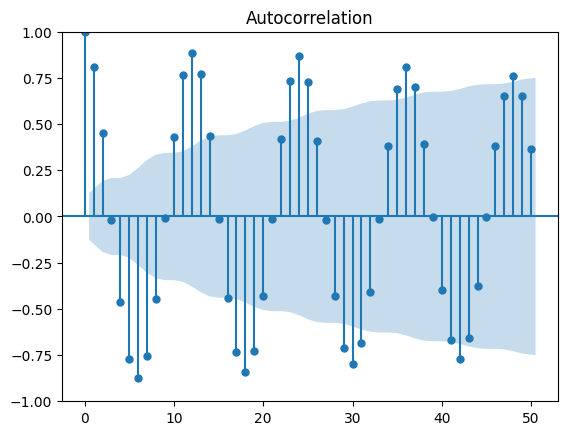

In [62]:
plot_acf(temps, lags=50) 
# не поняла, почему дублируется(

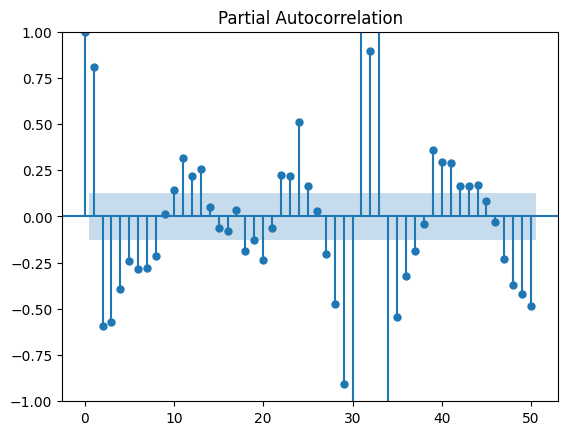

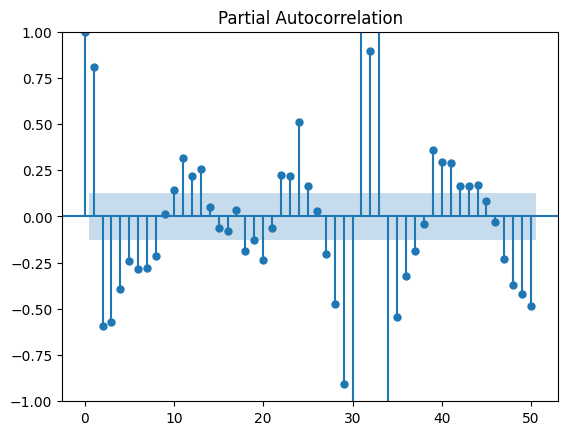

In [209]:
plot_pacf(temps, lags=50)

In [65]:
print(adfuller(temps)[1]) # ряд стационарный согласно тесту

0.016989030222608604


In [211]:
temps = boxcox(temps, 0)
temps = temps[1:] - temps[:-1]

In [212]:
model_garch = arch_model(temps, vol='GARCH', p=1, o=1, q=1, dist='StudentsT').fit(update_freq=5, disp='off')
print(model_garch.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                190.960
Distribution:      Standardized Student's t   AIC:                          -369.921
Method:                  Maximum Likelihood   BIC:                          -349.062
                                              No. Observations:                  239
Date:                      Sat, Jun 03 2023   Df Residuals:                      238
Time:                              16:40:31   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

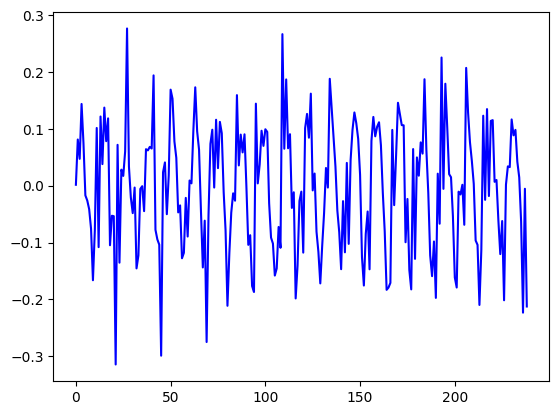

In [222]:
plt.plot(model_garch.resid, 'b') 

In [214]:
forecast = model_garch.forecast(horizon=100)

In [215]:
forecast.residual_variance.iloc[-1]

h.001    0.016201
h.002    0.012206
h.003    0.011908
h.004    0.011885
h.005    0.011884
           ...   
h.096    0.011884
h.097    0.011884
h.098    0.011884
h.099    0.011884
h.100    0.011884
Name: 238, Length: 100, dtype: float64

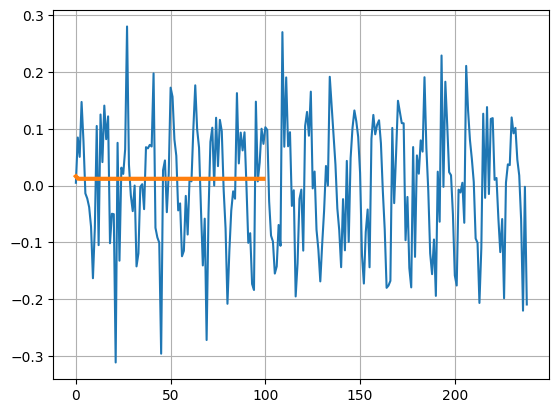

In [221]:
plt.plot(temps)
plt.plot(forecast.residual_variance.iloc[-1].values, linewidth=3) 
plt.grid()

In [199]:
def traintestsplit(data, lag_start=1, lag_end=20):
    
   for i in range(lag_start, lag_end):
        data[f'lag_{i}'] = data.Deg.shift(i)
  
   data = data.dropna()
   data = data.reset_index(drop=True)
  
   X_train = data.loc[:180].drop(['Deg'], axis=1)
   y_train = data.loc[:180]['Deg']
   X_test = data.loc[180:].drop(['Deg'], axis=1)
   y_test = data.loc[180:]['Deg']
    
   return X_train, X_test, y_train, y_test

In [149]:
X_train, X_test, y_train, y_test = traintestsplit(temps)

In [150]:
len(X_train), len(X_test), len(y_train), len(y_test)

(181, 31, 181, 31)

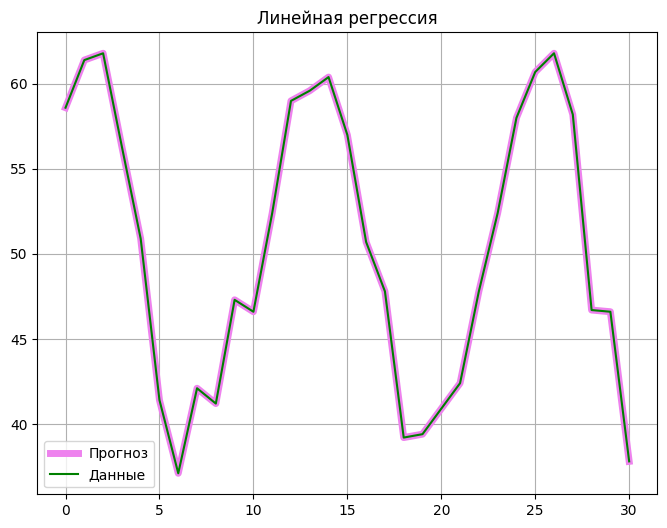

In [163]:
lin_reg = LinearRegression().fit(X_train, y_train)
prediction = lin_reg.predict(X_test)

plt.figure(figsize=(8, 6))
plt.plot(prediction, color='violet', label='Прогноз', linewidth=5)
plt.plot(y_test.values, color='green', label='Данные')
plt.legend()
plt.title('Линейная регрессия')
plt.grid(True);

In [152]:
rmse = np.sqrt(mean_squared_error(prediction, y_test))
print(f'Ошибка составляет: {round(rmse, 2)}')

# наверное и так бывает

Ошибка составляет: 0.0


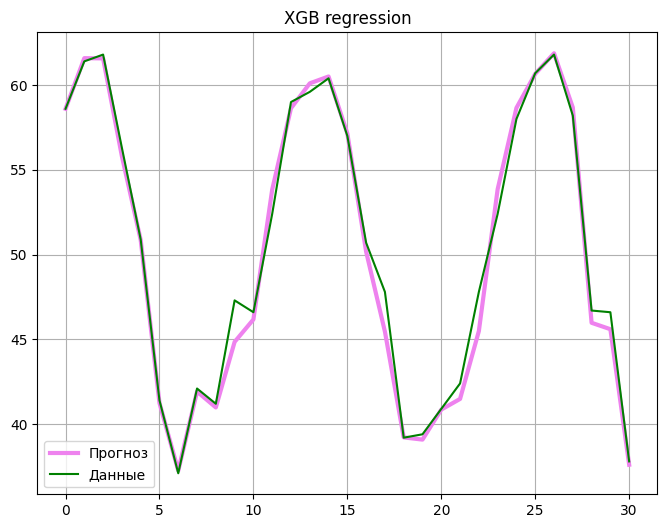

In [164]:
xgbr = XGBRegressor().fit(X_train, y_train)
prediction = xgbr.predict(X_test)

plt.figure(figsize=(8, 6))
plt.plot(prediction, color='violet', label='Прогноз', linewidth=3)
plt.plot(y_test.values, color='green', label='Данные')
plt.legend()
plt.title("XGB regression")
plt.grid(True);

In [161]:
rmse = np.sqrt(mean_squared_error(prediction, y_test))
print(f'Ошибка составляет: {round(rmse, 2)}')

Ошибка составляет: 0.91
